In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import os
import cv2
import numpy as np
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
image_directory = '/content/drive/MyDrive/Grad School/ASL-Data/data/train/matching_images'

# Get the list of image file names
image_files = os.listdir(image_directory)

# Load the images and assign labels manually
x_train = []
y_train = []

for filename in image_files:
    # Load the image
    image_path = os.path.join(image_directory, filename)
    image = keras.preprocessing.image.load_img(image_path, target_size=(128, 128))
    image_array = keras.preprocessing.image.img_to_array(image).astype('uint8')  # Convert to uint8
    
    # Add the image to the training data
    x_train.append(image_array)
    
    # Assign a label based on the filename or any other criteria
    # Modify this part according to your labeling requirements
    y_train.append(filename[0])

# Convert the lists to numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print('y_train shape:', y_train.shape)


x_train shape: (504, 128, 128, 3)
504 train samples
y_train shape: (504,)


In [ ]:
x_train = np.concatenate([x_train, x_train, x_train, x_train], axis=0)
y_train = np.concatenate([y_train, y_train, y_train,y_train], axis=0)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print('y_train shape:', y_train.shape)

x_train shape: (2016, 128, 128, 3)
2016 train samples
y_train shape: (2016,)


In [ ]:
image_directory = '/content/drive/MyDrive/Grad School/ASL-Data/data/test/matching_images'

# Get the list of image file names
image_files = os.listdir(image_directory)

# Load the images and assign labels manually
x_test = []
y_test = []

for filename in image_files:
    # Load the image
    image_path = os.path.join(image_directory, filename)
    image = keras.preprocessing.image.load_img(image_path, target_size=(128, 128))
    image_array = keras.preprocessing.image.img_to_array(image).astype('uint8')  # Convert to uint8
    
    # Add the image to the training data
    x_test.append(image_array)
    
    # Assign a label based on the filename or any other criteria
    # Modify this part according to your labeling requirements
    y_test.append(filename[0])

# Convert the lists to numpy arrays
x_test = np.array(x_test)
y_test = np.array(y_test)

print('x_test shape:', x_test.shape)
print(x_test.shape[0], 'test samples')
print('y_test shape:', y_test.shape)


x_test shape: (72, 128, 128, 3)
72 test samples
y_test shape: (72,)


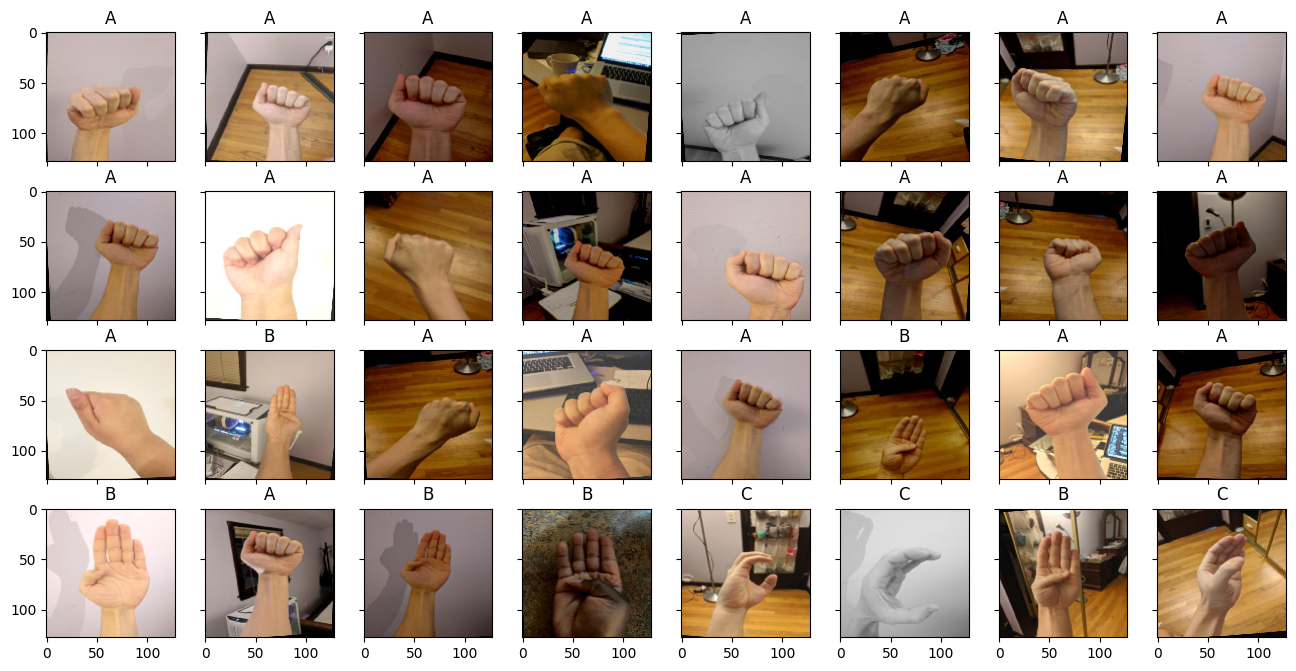

In [ ]:
sample_images = x_train[:32]
sample_labels = y_train[:32]

fig = plt.figure(figsize=(16., 8.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 8),  # creates 4x8 grid of axes
                 axes_pad=0.3  # pad between axes in inch
                 )

for ax, image, label in zip(grid, sample_images, sample_labels):
    ax.imshow(image)  # Convert image array to uint8 for proper display
    ax.set_title(label)

plt.show()


In [ ]:
## Ref: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.
class createAugment(keras.utils.Sequence):
  'Generates data for Keras'
  def __init__(self, X, y, batch_size=32, dim=(128, 128), n_channels=3, shuffle=True):
      'Initialization'
      self.batch_size = batch_size 
      self.X = X 
      self.y = y
      self.dim = dim
      self.n_channels = n_channels
      self.shuffle = shuffle
      
      self.on_epoch_end()

  def __len__(self):
      'Denotes the number of batches per epoch'
      return int(np.floor(len(self.X) / self.batch_size))

  def __getitem__(self, index):
      'Generate one batch of data'
      # Generate indexes of the batch
      indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

      # Generate data
      return self.__data_generation(indexes)

  def on_epoch_end(self):
      'Updates indexes after each epoch'
      self.indexes = np.arange(len(self.X))
      if self.shuffle:
          np.random.shuffle(self.indexes)

  def __data_generation(self, idxs):
    # X_batch is a matrix of masked images used as input
    X_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Masked image
    # y_batch is a matrix of original images used for computing error from reconstructed image
    y_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Original image

    ## Iterate through random indexes
    for i, idx in enumerate(idxs):
      image_copy = self.X[idx].copy()
  
      ## Get mask associated to that image
      masked_image = self.__createMask(image_copy)
      
      X_batch[i,] = masked_image/255
      y_batch[i] = self.y[idx]/255
      
    return X_batch, y_batch

  def __createMask(self, img):
    ## Prepare masking matrix
    mask = np.full((128,128,3), 255, np.uint8)
    for _ in range(np.random.randint(1, 10)):
      # Get random x locations to start line
      x1, x2 = np.random.randint(1, 128), np.random.randint(1, 128)
      # Get random y locations to start line
      y1, y2 = np.random.randint(1, 128), np.random.randint(1, 128)
      # Get random thickness of the line drawn
      thickness = np.random.randint(4, 12)
      # Draw black line on the white mask
      cv2.line(mask,(x1,y1),(x2,y2),(1,1,1),thickness)

    # Perforn bitwise and operation to mak the image
    masked_image = cv2.bitwise_and(img, mask)

    return masked_image

In [ ]:
## Prepare training and testing mask-image pair generator
traingen = createAugment(x_train, x_train)
testgen = createAugment(x_test, x_test, shuffle=False)

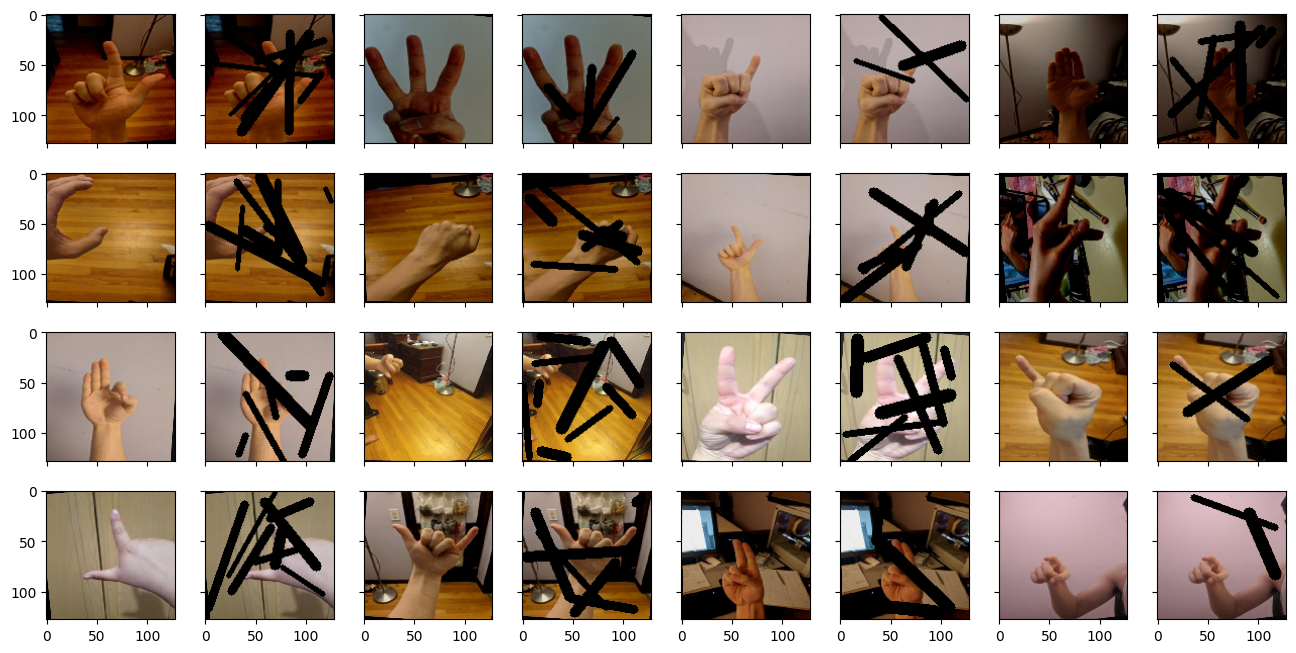

In [ ]:
## Examples
sample_idx = 2 ## Change this to see different batches

sample_masks, sample_labels = traingen[sample_idx]
sample_images = [None]*(len(sample_masks)+len(sample_labels))
sample_images[::2] = sample_labels
sample_images[1::2] = sample_masks

fig = plt.figure(figsize=(16., 8.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 8),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )

for ax, image in zip(grid, sample_images):
  ax.imshow(image)

plt.show()

In [ ]:
## For more information into formulation: https://www.youtube.com/watch?v=AZr64OxshLo
## Metric
def dice_coef(y_true, y_pred):
    y_true_f = keras.backend.flatten(y_true)
    y_pred_f = keras.backend.flatten(y_pred)
    intersection = keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (keras.backend.sum(y_true_f + y_pred_f))

In [ ]:
class InpaintingModel:
    '''
    Build UNET-like model for image inpainting task.
    '''
    def prepare_model(self, input_size=(128, 128, 3)):
        inputs = keras.layers.Input(input_size)

        conv1, pool1 = self.__ConvBlock(32, (3, 3), (2, 2), 'relu', 'same', inputs)
        conv2, pool2 = self.__ConvBlock(64, (3, 3), (2, 2), 'relu', 'same', pool1)
        conv3, pool3 = self.__ConvBlock(128, (3, 3), (2, 2), 'relu', 'same', pool2)
        conv4, pool4 = self.__ConvBlock(256, (3, 3), (2, 2), 'relu', 'same', pool3)

        conv5, up6 = self.__UpConvBlock(512, 256, (3, 3), (2, 2), (2, 2), 'relu', 'same', pool4, conv4)
        conv6, up7 = self.__UpConvBlock(256, 128, (3, 3), (2, 2), (2, 2), 'relu', 'same', up6, conv3)
        conv7, up8 = self.__UpConvBlock(128, 64, (3, 3), (2, 2), (2, 2), 'relu', 'same', up7, conv2)
        conv8, up9 = self.__UpConvBlock(64, 32, (3, 3), (2, 2), (2, 2), 'relu', 'same', up8, conv1)

        conv9 = self.__ConvBlock(32, (3, 3), (2, 2), 'relu', 'same', up9, False)

        outputs = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(conv9)

        return keras.models.Model(inputs=[inputs], outputs=[outputs])

    def __ConvBlock(self, filters, kernel_size, pool_size, activation, padding, connecting_layer, pool_layer=True):
        conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(
            connecting_layer)
        conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(
            conv)
        if pool_layer:
            pool = keras.layers.MaxPooling2D(pool_size)(conv)
            return conv, pool
        else:
            return conv

    def __UpConvBlock(self, filters, up_filters, kernel_size, up_kernel, up_stride, activation, padding,
                      connecting_layer, shared_layer):
        conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(
            connecting_layer)
        conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(
            conv)
        up = keras.layers.Conv2DTranspose(filters=up_filters, kernel_size=up_kernel, strides=up_stride,
                                          padding=padding)(conv)
        up = keras.layers.concatenate([up, shared_layer], axis=3)

        return conv, up

In [ ]:
keras.backend.clear_session()
model = InpaintingModel().prepare_model()
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[dice_coef])

In [ ]:
_ = model.fit(traingen, 
          validation_data=testgen, 
          epochs=20, 
          steps_per_epoch=len(traingen), 
          validation_steps=len(testgen),
          use_multiprocessing=True)

Epoch 1/20
63/63 [==============================] - 42s 352ms/step - loss: 0.1192 - dice_coef: 0.5431 - val_loss: 0.0617 - val_dice_coef: 0.5726
Epoch 2/20
63/63 [==============================] - 18s 290ms/step - loss: 0.0508 - dice_coef: 0.5823 - val_loss: 0.0438 - val_dice_coef: 0.5556
Epoch 3/20
63/63 [==============================] - 23s 350ms/step - loss: 0.0444 - dice_coef: 0.5849 - val_loss: 0.0424 - val_dice_coef: 0.5553
Epoch 4/20
63/63 [==============================] - 23s 365ms/step - loss: 0.0380 - dice_coef: 0.5872 - val_loss: 0.0334 - val_dice_coef: 0.5680
Epoch 5/20
63/63 [==============================] - 23s 365ms/step - loss: 0.0354 - dice_coef: 0.5894 - val_loss: 0.0356 - val_dice_coef: 0.5726
Epoch 6/20
63/63 [==============================] - 24s 376ms/step - loss: 0.0339 - dice_coef: 0.5905 - val_loss: 0.0339 - val_dice_coef: 0.5647
Epoch 7/20
63/63 [==============================] - 20s 313ms/step - loss: 0.0325 - dice_coef: 0.5906 - val_loss: 0.0301 - val_dic

1/1 [==============================] - 0s 20ms/step


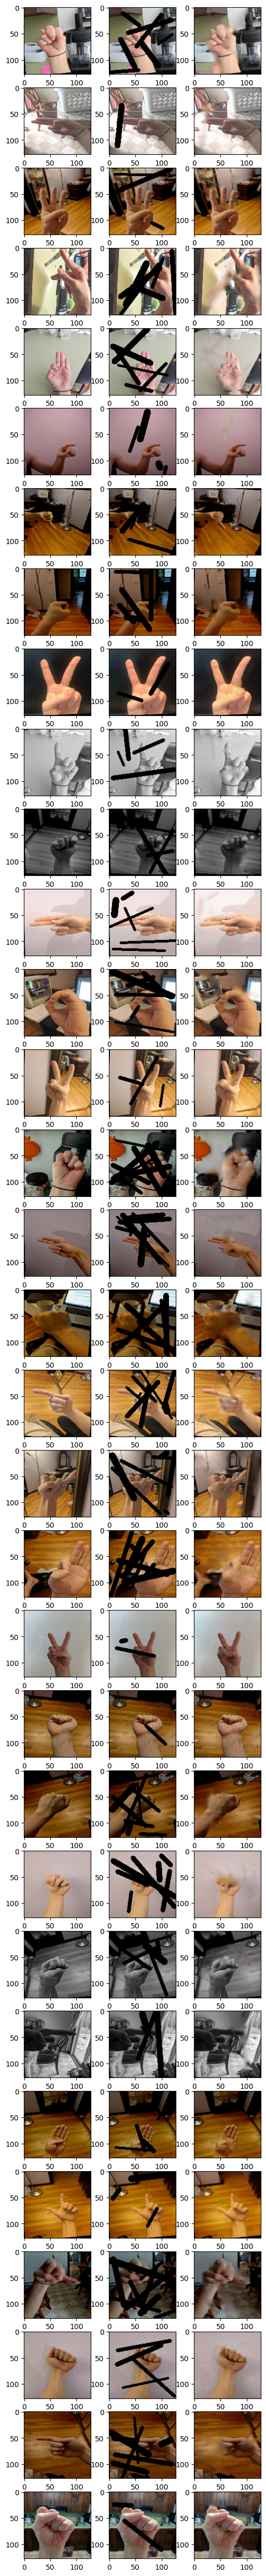

In [ ]:
## Examples
rows = 32
sample_idx = 2
sample_images, sample_labels = traingen[sample_idx]

fig, axs = plt.subplots(nrows=rows, ncols=3, figsize=(6, 2*rows))

for i in range(32):
  impainted_image = model.predict(sample_images[i].reshape((1,)+sample_images[i].shape))
  axs[i][0].imshow(sample_labels[i])
  axs[i][1].imshow(sample_images[i])
  axs[i][2].imshow(impainted_image.reshape(impainted_image.shape[1:]))

plt.show()